In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:41963")
client

<Client: 'tcp://127.0.0.1:41963' processes=8 threads=40, memory=157.35 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
from xhistogram.xarray import histogram as xhist
from xgcm.grid import Grid
import xrft
import gsw

import glob

import gcm_filters

import seaborn as sns

import os.path as op

# from xeofs.models import EOF
# from pydmd import DMD, BOPDMD, MrDMD
from pydmd.mrcosts import mrCOSTS
from pydmd.preprocessing import hankel_preprocessing
from pydmd.plotter import plot_eigs, plot_summary

from matplotlib import ticker
import matplotlib.colors as clr
import matplotlib.pyplot as plt
plt.rcParams['pcolor.shading'] = 'auto'
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
ddir = '/tank/spectre/tuchida/DMD/'

In [5]:
# ds = xr.open_dataset(op.join(ddir,'wave-vortex/data/dmd-eddy-tide.nc')
#                     ).chunk({'t':100,'z':1,'y':128,'x':128})
# ds.to_zarr(op.join(ddir,'wave-vortex/data/dmd-eddy-tide.zarr'))
ds = xr.open_zarr(op.join(ddir,'wave-vortex/data/dmd-eddy-tide.zarr'))
ds

<xarray.Dataset>
Dimensions:          (t: 3457, kl: 11439, j: 19, z: 30, y: 256, x: 256)
Coordinates:
  * j                (j) float64 0.0 1.0 2.0 3.0 4.0 ... 15.0 16.0 17.0 18.0
  * kl               (kl) float64 0.0 1.0 2.0 ... 1.144e+04 1.144e+04 1.144e+04
  * t                (t) datetime64[ns] 1970-01-09 ... 1970-03-22
  * x                (x) float64 0.0 2.209e+03 4.418e+03 ... 5.611e+05 5.633e+05
  * y                (y) float64 0.0 2.209e+03 4.418e+03 ... 5.611e+05 5.633e+05
  * z                (z) float64 -4e+03 -3.302e+03 ... -43.49 -1.137e-10
Data variables: (12/39)
    A0_imagp         (t, kl, j) float64 dask.array<chunksize=(100, 11439, 19), meta=np.ndarray>
    A0_realp         (t, kl, j) float64 dask.array<chunksize=(100, 11439, 19), meta=np.ndarray>
    A0bar            (kl, j) float64 dask.array<chunksize=(11439, 19), meta=np.ndarray>
    Am_imagp         (t, kl, j) float64 dask.array<chunksize=(100, 11439, 19), meta=np.ndarray>
    Am_realp         (t, kl, j) float64 dask.array<chunksize=(100, 11439, 19), meta=np.ndarray>
    Ambar_imagp      (kl, j) float64 dask.array<chunksize=(11439, 19), meta=np.ndarray>
    ...               ...
    ssh_pv           (t, y, x) float64 dask.array<chunksize=(100, 128, 128), meta=np.ndarray>
    ssh_w            (t, y, x) float64 dask.array<chunksize=(100, 128, 128), meta=np.ndarray>
    t0               float64 ...
    tau0             float64 ...
    tauM             float64 ...
    tauP             float64 ...
Attributes:
    WVNonlinearFluxOperation:  WVNonlinearFluxForced
    WVTransform:               WVTransformHydrostatic
    date_created:              30-Sep-2024 17:03:43
    history:                   30-Sep-2024 17:03:43: file created.~          ...
    model_version:             3.0
    nu_xy:                     139.98260255746277
    nu_z:                      0.0
    r:                         5.787037037037037e-08
    references:                Early, J., Lelong, M., & Sundermeyer, M. (2021...
    shouldUseLinearDynamics:   0
    source:                    Created with the WaveVortexModel version 3

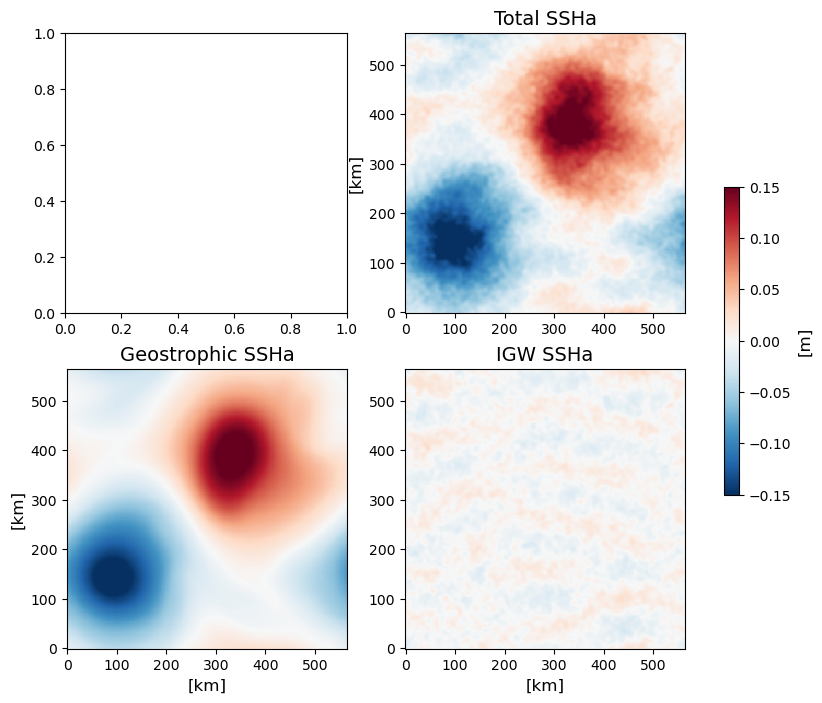

In [39]:
fig, axes = plt.subplots(figsize=(10,8), nrows=2, ncols=2)
# fig.set_tight_layout(True)

im = axes[0,1].pcolormesh(ds.x*1e-3, ds.y*1e-3, ds.ssh.isel(t=200),
                     cmap='RdBu_r', vmin=-.15, vmax=.15,
                     rasterized=True)
axes[1,0].pcolormesh(ds.x*1e-3, ds.y*1e-3, ds.ssh_pv.isel(t=200),
                     cmap='RdBu_r', vmin=-.15, vmax=.15,
                     rasterized=True)
axes[1,1].pcolormesh(ds.x*1e-3, ds.y*1e-3, ds.ssh_w.isel(t=200),
                     cmap='RdBu_r', vmin=-.15, vmax=.15,
                     rasterized=True)

axes[0,1].set_aspect('equal')
axes[1,0].set_aspect('equal')
axes[1,1].set_aspect('equal')

axes[0,1].set_ylabel('[km]', fontsize=12)
axes[1,0].set_ylabel('[km]', fontsize=12)
axes[1,0].set_xlabel('[km]', fontsize=12)
axes[1,1].set_xlabel('[km]', fontsize=12)

axes[0,1].set_title("Total SSHa", fontsize=14)
axes[1,0].set_title("Geostrophic SSHa", fontsize=14)
axes[1,1].set_title("IGW SSHa", fontsize=14)

cbar = fig.colorbar(im, ax=axes, shrink=.5)
cbar.set_label(r"[m]", fontsize=12)

plt.savefig(op.join(ddir,'Figs/wave-vortex-SSH.pdf'))

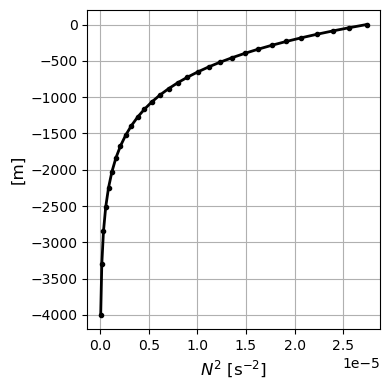

In [38]:
fig, ax = plt.subplots(figsize=(4,4))
fig.set_tight_layout(True)

ax.plot(ds.N2, ds.z, 'k.-', lw=2)
ax.grid(True)
ax.set_ylabel(r"[m]", fontsize=12)
ax.set_xlabel(r"$N^2$ [s$^{-2}$]", fontsize=12)
# ax.set_xscale('log')
plt.savefig(op.join(ddir,'Figs/wave-vortex-N2.pdf'))

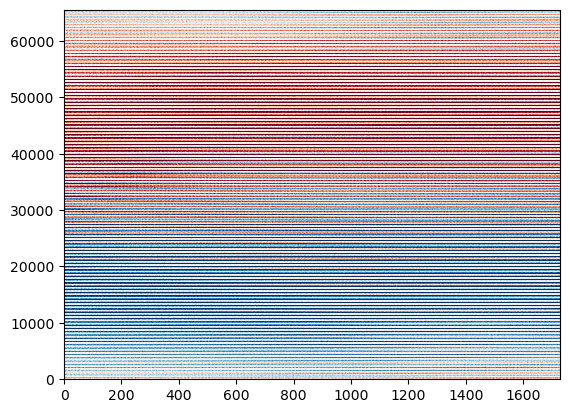

<xarray.DataArray 'ssh' (z: 65536, t: 1729)>
dask.array<transpose, shape=(65536, 1729), dtype=float64, chunksize=(1750, 50), chunktype=numpy.ndarray>
Coordinates:
  * t        (t) datetime64[ns] 1970-01-09 1970-01-09T01:00:00 ... 1970-03-22
  * z        (z) object MultiIndex
  * y        (z) float64 0.0 0.0 0.0 0.0 ... 5.633e+05 5.633e+05 5.633e+05
  * x        (z) float64 0.0 2.209e+03 4.418e+03 ... 5.611e+05 5.633e+05
Attributes:
    long_name:  sea-surface height
    units:      m

In [7]:
zchunk = 1750
nh = 2
h_stacked = ds.ssh[::nh].stack(z=("y","x")).chunk({'z':zchunk})

fig, ax = plt.subplots()
ax.pcolormesh(h_stacked.T.values, 
              rasterized=True, vmax=.1, vmin=-.1, cmap='RdBu_r')
plt.show()
h_stacked.T

In [8]:
# window_lengths = (np.array([24, 8*24])).astype(int) # 1 hourly, 6 layers
# step_sizes = np.array([2, 8])
window_lengths = (np.array([12, 24, 48, 16*24]) / nh).astype(int) # 2 hourly, 6 layers
step_sizes = np.array([2, 4, 6, 8])

print(window_lengths, 
      window_lengths*(3600)/86400, '[days]')

[  6  12  24 192] [0.25 0.5  1.   8.  ] [days]


In [9]:
fit = False

In [9]:
if len(window_lengths) == 2:
    # sr = 6
    # svd_ranks = [sr] * len(window_lengths)
    svd_ranks = [8, 18]
    if len(svd_ranks) != len(window_lengths):
        print("######### WRONG LENGTHS #########")
elif len(window_lengths) == 4:
    # svd_ranks = [4, 4, 4, 6, 10]
    svd_ranks = [4, 8, 10, 18]
    if len(svd_ranks) != len(window_lengths):
        print("######### WRONG LENGTHS #########")
suppress_growth = True
transform_method = "absolute"
# n_components_array = [2] * len(window_lengths)
global_svd_array = [False] * len(window_lengths)

dmd = mrCOSTS(
    svd_rank_array=svd_ranks,
    window_length_array=window_lengths,
    step_size_array=step_sizes,
    global_svd_array=global_svd_array,
    cluster_sweep=True,
    transform_method=transform_method,
    # pydmd_kwargs={'eig_constraints':{"imag", "conjugate_pairs"}},
    # n_components_array=n_components_array,
)

if fit:
    dmd.fit(h_stacked.values.T, 
            np.atleast_2d(np.arange(len(h_stacked.t))*3600.)
           )

_________________________________________________
Fitting window length = 24
0 of 854
50 of 854
100 of 854
150 of 854
200 of 854
250 of 854
300 of 854
350 of 854
400 of 854
450 of 854
500 of 854
550 of 854
600 of 854
650 of 854
700 of 854
750 of 854
800 of 854
850 of 854
Error in Global Reconstruction = 0.047
_________________________________________________
Fitting window length = 192
0 of 194
50 of 194
100 of 194
150 of 194
Error in Global Reconstruction = 0.014


In [10]:
if fit:
    dmd.to_netcdf(op.join(ddir, 
                          "wave-vortex/mrCOSTS_h/%02dhourly/%02d_fit_new"
                          % (nh//2,len(window_lengths))
                         )
                 )
else:
    mrc = glob.glob(op.join(ddir, 
                            "wave-vortex/mrCOSTS_h/%02dhourly/%02d_fit_new*.nc"
                            % (nh//2,len(window_lengths))
                           )
                   )
    print(mrc)
    dmd = mrCOSTS()
    dmd.from_netcdf(mrc)

['/tank/spectre/tuchida/DMD/wave-vortex/mrCOSTS_h/01hourly/04_fit_new.window=48.nc', '/tank/spectre/tuchida/DMD/wave-vortex/mrCOSTS_h/01hourly/04_fit_new.window=12.nc', '/tank/spectre/tuchida/DMD/wave-vortex/mrCOSTS_h/01hourly/04_fit_new.window=384.nc', '/tank/spectre/tuchida/DMD/wave-vortex/mrCOSTS_h/01hourly/04_fit_new.window=24.nc']


In [11]:
# Plot the 3rd decomposition level
n_decomp = 1
mrd = dmd.costs_array[n_decomp]

# The data for each decomposition level is built here to avoid
# reconstructing the data for each plot. If this is not done the
# plots can still be rendered but will take slightly longer.
if n_decomp == 0:
    x_iter = data
else:
    x_iter, _ = dmd.costs_array[n_decomp - 1].scale_separation(
        scale_reconstruction_kwargs=dmd._costs_recon_kwargs
    )

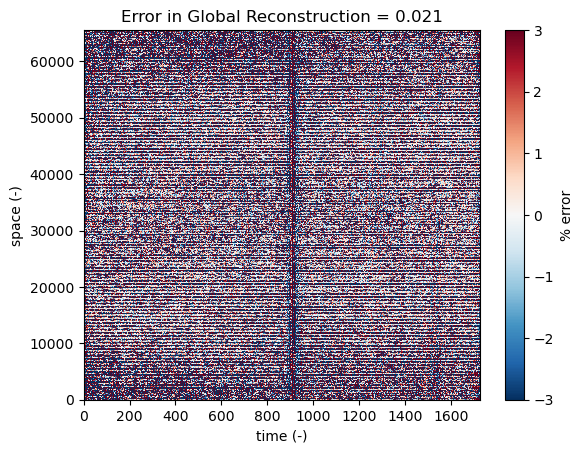

In [12]:
# Error in global reconstruction
dmd.plot_local_error(
    n_decomp, data=x_iter, scale_reconstruction_kwargs=dmd._costs_recon_kwargs
)

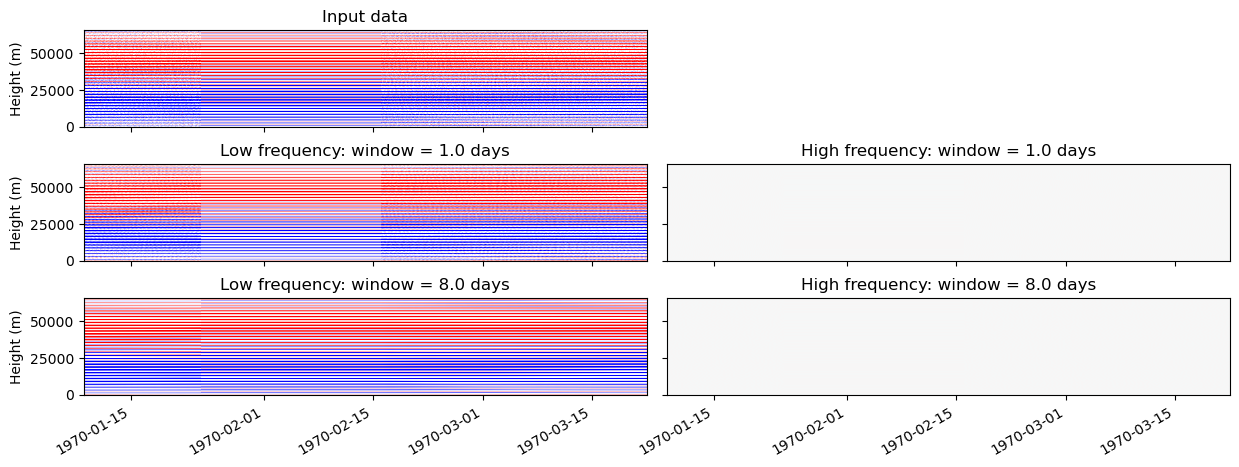

In [28]:
vscale = 10
fig, axes = plt.subplots(
    dmd.n_decompositions + 1,
    2,
    figsize=(6.25*2, dmd.n_decompositions * 1.25*2),
    sharex=True,
    sharey=True,
)

plot_kwargs = {
    "cmap": "RdBu_r",
    "vmin": -vscale,
    "vmax": vscale,
}

plot_kwargs_lf = {
    "cmap": "bwr",
    "vmin": -.1,
    "vmax": .1,
}

ax = axes[0, 0]
ax.pcolormesh(h_stacked.t.values, np.arange(len(h_stacked.z)), 
              h_stacked.T, **plot_kwargs_lf)
ax.set_title("Input data")
ax.set_ylabel("Height (m)")

axes[0, 1].axis("off")
for nm, m in enumerate(dmd.costs_array):
    xr_low_frequency, xr_high_frequency = m.scale_separation()

    ax = axes[nm + 1, 1]
    ax.pcolormesh(
        h_stacked.t.values, np.arange(len(h_stacked.z)), 
        xr_high_frequency, **plot_kwargs
    )
    ax.set_title(
        "High frequency: window = {} days".format(m._window_length*3600./86400.))

    ax = axes[nm + 1, 0]
    ax.pcolormesh(
        h_stacked.t.values, 
        np.arange(len(h_stacked.z)),
        xr_low_frequency,
        **plot_kwargs_lf
    )
    ax.set_title(
        "Low frequency: window = {} days".format(m._window_length*3600./86400.))
    ax.set_ylabel("Height (m)")

# axes[-1, 0].xaxis.set_major_formatter(DateFormatter("%H:%M"))

fig.tight_layout()
fig.autofmt_xdate()

In [11]:
dmd.multi_res_interp()
dmd._da_omega

<xarray.DataArray 'omega' (window_length: 4, window_time_means: 860,
                           svd_rank: 18)>
array([[[           nan       +nanj,            nan       +nanj,
         1.18152333e-05+0.00029921j, ...,            nan       +nanj,
                    nan       +nanj,            nan       +nanj],
        [           nan       +nanj,            nan       +nanj,
         1.54970350e-05+0.00030498j, ...,            nan       +nanj,
                    nan       +nanj,            nan       +nanj],
        [           nan       +nanj,            nan       +nanj,
         1.62212438e-05+0.00030494j, ...,            nan       +nanj,
                    nan       +nanj,            nan       +nanj],
        ...,
        [           nan       +nanj,            nan       +nanj,
         1.49205087e-05+0.0003072j , ...,            nan       +nanj,
                    nan       +nanj,            nan       +nanj],
        [           nan       +nanj,            nan       +nanj,
         1.69441204e-05+0.00030952j, ...,            nan       +nanj,
                    nan       +nanj,            nan       +nanj],
        [           nan       +nanj,            nan       +nanj,
         1.56042487e-05+0.00030988j, ...,            nan       +nanj,
                    nan       +nanj,            nan       +nanj]],

...

       [[           nan       +nanj,            nan       +nanj,
                    nan       +nanj, ...,            nan       +nanj,
                    nan       +nanj,            nan       +nanj],
        [           nan       +nanj,            nan       +nanj,
                    nan       +nanj, ...,            nan       +nanj,
                    nan       +nanj,            nan       +nanj],
        [           nan       +nanj,            nan       +nanj,
                    nan       +nanj, ...,            nan       +nanj,
                    nan       +nanj,            nan       +nanj],
        ...,
        [           nan       +nanj,            nan       +nanj,
                    nan       +nanj, ...,            nan       +nanj,
                    nan       +nanj,            nan       +nanj],
        [           nan       +nanj,            nan       +nanj,
                    nan       +nanj, ...,            nan       +nanj,
                    nan       +nanj,            nan       +nanj],
        [           nan       +nanj,            nan       +nanj,
                    nan       +nanj, ...,            nan       +nanj,
                    nan       +nanj,            nan       +nanj]]])
Coordinates:
  * window_time_means    (window_time_means) float64 1.98e+04 ... 6.201e+06
  * svd_rank             (svd_rank) int64 0 1 2 3 4 5 6 ... 11 12 13 14 15 16 17
    slide                (window_length, window_time_means) float64 0.0 ... 1...
  * window_length        (window_length) int64 12 24 48 384
    decomposition_level  (window_length) int64 0 1 2 3

fitting n_components = 3
fitting n_components = 4
fitting n_components = 5
fitting n_components = 6
fitting n_components = 7
fitting n_components = 8
fitting n_components = 9
fitting n_components = 10
fitting n_components = 11
fitting n_components = 12
fitting n_components = 13
fitting n_components = 14
fitting n_components = 15
fitting n_components = 16
fitting n_components = 17
fitting n_components = 18
fitting n_components = 19
Optimal silhouette score is = 8


Text(0, 0.5, 'Silhouette score (-), (1 is best, -1 is worst)')

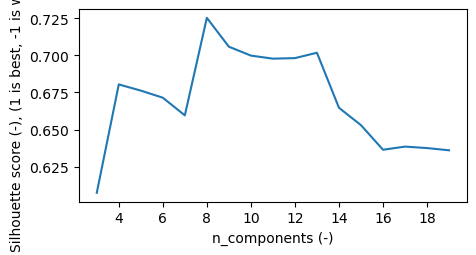

In [12]:
da = dmd._da_omega
omega = da.values
omega = omega.reshape(
    len(da.window_length), len(da.window_time_means) * len(da.svd_rank)
)

n_components_range = np.arange(3, 20)
scores, n_optimal = dmd.global_cluster_hyperparameter_sweep(
    n_components_range,
    transform_method="log10",
)

print("Optimal silhouette score is = {}".format(n_optimal))
plt.figure(figsize=(5, 2.5))
plt.plot(n_components_range, scores)
plt.gca().set_xlabel("n_components (-)")
plt.gca().set_ylabel("Silhouette score (-), (1 is best, -1 is worst)")

Text(0.5, 1.0, 'Normalized mode spatial amplitude for each decomp. level')

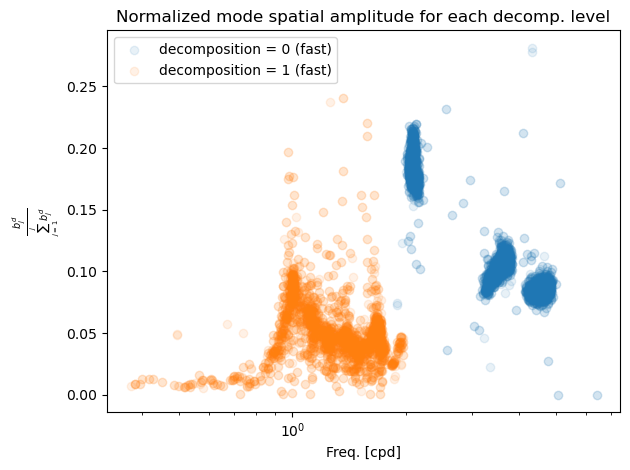

In [20]:
fig, ax = plt.subplots(1, 1)
fig.set_tight_layout(True)
for nm, m in enumerate(dmd.costs_array):
    # Extract out the amplitudes of the spatial modes
    b = m.amplitudes_array
    mode_periods = m.periods()

    # Ratio of spatial amplitude for each mode relative to the amplitudes for all
    # high frequency modes (selected using the `omega_classes > 0` indexing)
    sum_b_ratio = (b.T / np.sum(b, axis=1)).T[m.omega_classes > 0].real

    ax.scatter(
        x=mode_periods**-1*86400,
        y=sum_b_ratio,
        alpha=0.1,
        label="decomposition = {} (fast)".format(nm),
    )

    # # Ratio of spatial amplitude for each mode relative to the amplitudes for all
    # # low frequency modes (selected using the `omega_classes == 0` indexing)
    # sum_b_ratio = (b.T / np.sum(b, axis=1)).T[m.omega_classes == 0].real

    # ax.scatter(
    #     x=mode_periods**-1*86400,
    #     y=sum_b_ratio[:len(mode_periods)],
    #     alpha=0.1,
    #     marker='x',
    #     label="decomposition = {} (slow)".format(nm),
    # )

# ax.set_ylim(0, 0.25)
ax.legend()
ax.set_xscale("log")
ax.set_ylabel(r"$\frac{b^{d}_j}{\sum^{j}_{j=1}b^{d}_j}$")
ax.set_xlabel("Freq. [cpd]")
ax.set_title("Normalized mode spatial amplitude for each decomp. level")

In [33]:
cluster_centroids, omega_classes, omega_array = dmd.global_cluster_omega(
    n_optimal, transform_method="log10"
)
cluster_centers_periods = 1 / (10 ** (cluster_centroids) / (2 * np.pi))

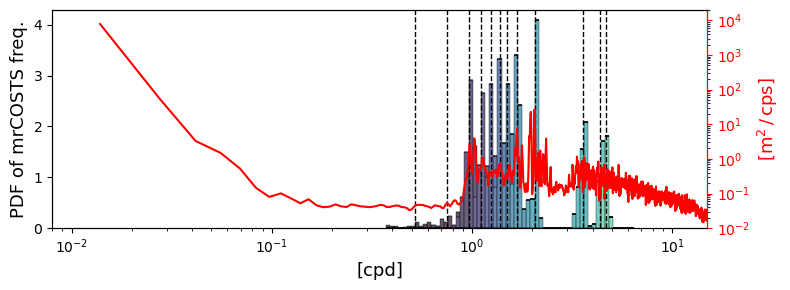

In [43]:
x_trans = (2 * np.pi / 10**omega_array / 86400.)**-1
# unique_labels, label_counts = np.unique(omega_classes, return_counts=True)
# weights = label_counts.max() / label_counts
# x_trans_labels = [x_trans[omega_classes == label] for label in unique_labels]

# weights_labels = []
# unique_labels = unique_labels.astype(int)
# for label in unique_labels:
#     ind_array = np.flatnonzero(unique_labels == label)
#     ind_list = int(ind_array)
#     w = weights[ind_array]
#     x_w = x_trans_labels[ind_list]
#     w_broadcast = np.broadcast_to(w, (x_w.shape))
#     weights_labels.append(w_broadcast)
hue_order = np.arange(len(np.unique(omega_classes))).astype(str)
cluster_centers = 1 / ((10 ** cluster_centroids) / (2 * np.pi) / 86400.)

# Make a continuous color palette with the brightest and darkest excluded
palette = sns.color_palette("mako", len(cluster_centers) + 2)
# palette = palette[1:-1]


Fh = xrft.power_spectrum(ds.ssh.isel(y=np.arange(0,len(ds.y),65),
                                  x=np.arange(0,len(ds.x),65)
                        ).chunk({'t':-1}
                               ).assign_coords({'t':np.arange(len(ds.t)
                                                             ) * 1800.}), 
                         dim='t', window='hann', window_correction=True
                        ).astype(np.single)

from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(figsize=(8, 3))
ax2 = ax.twinx()
fig.set_tight_layout(True)

ax2.plot(Fh.freq_t.isel(freq_t=slice(len(Fh.freq_t)//2+1,None))*86400, 
        Fh.isel(freq_t=slice(len(Fh.freq_t)//2+1,None)
               ).mean(['y','x'])*2, 
        c='r', label=r"Fourier")

# ax = plt.gca()
ax.set_xscale("log")
# ax2.set_xscale("log")
ax2.set_yscale("log")
# ax.set_title(
#     "Global histogram of frequencies; Interpolated decomposition levels"
# )
# ax.set_xlabel(r"Period; $(2 \pi) / Im(|\omega|)$ [day]")

# ax.hist(
#     x=x_trans_labels,
#     bins=np.logspace(stop=np.log10((1.9e4/86400)**-1), 
#                      start=np.log10((1.5e6/86400)**-1), 
#                      num=200),
#     histtype="barstacked",
#     weights=weights_labels,
#     # alpha=.8,
# )
sns.histplot(
    # x=((10**omega_array) / (2 * np.pi) / 86400.),
    x=x_trans,
    hue=omega_classes,
    hue_order=hue_order,
    common_bins=True,
    common_norm=True,
    stat="density",
    multiple="stack",
    bins=60,
    palette=ListedColormap(palette,N=n_optimal),
    legend=False,
    ax=ax
)

ax.set_xlabel(r"[cpd]", fontsize=13)
ax.set_ylabel("PDF of mrCOSTS freq.", fontsize=13)
ax2.set_ylabel("[m$^2\,/\,$cps]", fontsize=13, c='r')

ax.set_xlim([8e-3,1.5e1])
# ax2.set_xlim([8e-3,1.5e1])
ax2.set_ylim([1e-2,2e4])

# ax2.fill_between(np.array([1/(nh//2*3600.)*86400, 1/(2*1800.)*86400]), 
#                  5e-5, 2e4, 
#                  color='r', alpha=.15)
ax2.spines['right'].set_color('red')
ax2.tick_params(axis='y', colors='red')

[
    ax.axvline((2 * np.pi / (10**c) / 86400)**-1, color="k", ls="--", lw=1)
    for nc, c in enumerate(cluster_centroids)
];
# ylim_bottom, ylim_top = ax.get_ylim()
# [
#     ax.text(
#         2 * np.pi / (10**c),
#         ylim_top - ylim_top * 0.1,
#         "{:4.0f}d".format(1 / (10 ** (c) / (2 * np.pi))),
#         rotation="vertical",
#         va="top",
#         ha="right",
#     )
#     for c in cluster_centroids
# ];

# y_lim_bottom, y_lim_top = ax.get_ylim()
# [
#     ax.text(
#         c,
#         y_lim_top - y_lim_top * 0.2,
#         # "{:0.2f} Hz".format(c),
#         rotation="vertical",
#         va="top",
#         ha="right",
#     )
#     for c in cluster_centers
# ];
plt.savefig(op.join(ddir,'Figs/W-V_mrCOSTS_hist_%02dh-%02d.pdf' 
                    % (nh//2,len(window_lengths)))
           )

In [44]:
omega_classes_list = dmd.multi_res_deterp()

In [45]:
save = False

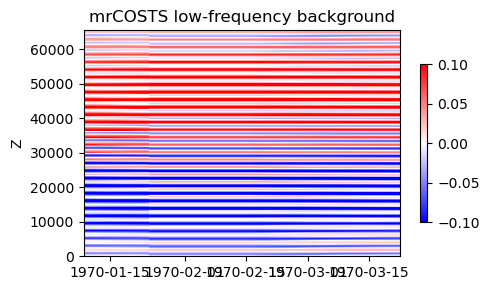

In [46]:
xr_background = dmd.get_background()

if save:
    ds_global_background = xr.DataArray(xr_background, dims=h_stacked.T.dims,
                                        coords=h_stacked.T.coords
                                       ).unstack().chunk({'t':10})
    ds_global_background.chunk(
    #         {'lat':100, 'lon':100}
    ).to_dataset(name='background'
                ).to_zarr(op.join(ddir,
                'wave-vortex/mrCOSTS_h/%02dhourly/%02d-recons/background.zarr' 
                                  % (nh//2, len(window_lengths))),
                                  mode='w')

fig, ax = plt.subplots(figsize=(5, 3))
fig.set_tight_layout(True)
im = ax.pcolormesh(
    h_stacked.t,
    np.arange(len(h_stacked.z)), 
    xr_background, 
    vmin=-.1, vmax=.1, cmap="bwr",
    rasterized=True
)
ax.set_title("mrCOSTS low-frequency background")
ax.set_ylabel("Z")
# fig.autofmt_xdate()
fig.colorbar(im, shrink=.7)

In [47]:
xr_sep = dmd.global_scale_reconstruction()

In [48]:
if save:
    for ncl_center, cl_center in enumerate(cluster_centers_periods):
    
        ds_xr_sep = xr.DataArray(
            xr_sep.real[:, ncl_center],
            dims=["decomp_level", "z", "t"],
            coords=[
                np.arange(len(dmd.costs_array)),
                # np.arange(n_optimal),
                h_stacked.z,
                h_stacked.t,
            ],
        )
    
        for dd in ds_xr_sep.decomp_level:
            if dd == 0:
                ds_global_separation = ds_xr_sep.sel(decomp_level=dd
                                                    ).unstack().chunk({'t':10})
            else:
                ds_global_separation = xr.concat([ds_global_separation,
                                                  ds_xr_sep.sel(decomp_level=dd
                                                      ).unstack().chunk({'t':10})
                                                 ], 'decomp_level'
                                                )
        
        # ds_xr_sep.isel(decomp_level=0).sum("cluster").plot(rasterized=True)
        ds_cluster_centers = xr.DataArray(
            np.array([1 / (10 ** (cluster_centroids[ncl_center]) / (2 * np.pi)),]),
            dims=["cluster"],
            # coords=[np.arange(n_optimal)],
            coords=[np.array([ncl_center,])],
        )
        ds_cluster_centers.attrs["units"] = "s"
        ds_cluster_centers.attrs["long_name"] = "Central period of each period band"
        
        ds_global_separation = ds_global_separation.to_dataset(name="frequency_bands")
        ds_global_separation["frequency_bands"].attrs["units"] = "m"
        ds_global_separation["frequency_bands"].attrs["long_name"] = "mrCOSTS"
        
        ds_global_separation.coords["cluster_centers"] = ds_cluster_centers
    
        if ncl_center == 0:
            print(ds_global_separation)
            
        ds_global_separation.chunk(
                    # {'time':1,'decomp_level':1}
                    ).to_zarr(op.join(ddir,
        'wave-vortex/mrCOSTS_h/%02dhourly/%02d-recons/cluster%02d.zarr' 
                          % (nh//2, len(window_lengths), ncl_center)),
                          mode='w')
        print(ncl_center)

<xarray.Dataset>
Dimensions:          (y: 256, x: 256, decomp_level: 2, t: 1729, cluster: 1)
Coordinates:
  * y                (y) float64 0.0 2.209e+03 4.418e+03 ... 5.611e+05 5.633e+05
  * x                (x) float64 0.0 2.209e+03 4.418e+03 ... 5.611e+05 5.633e+05
  * decomp_level     (decomp_level) int64 0 1
  * t                (t) datetime64[ns] 1970-01-09 ... 1970-03-22
  * cluster          (cluster) int64 0
    cluster_centers  (cluster) float64 1.67e+05
Data variables:
    frequency_bands  (decomp_level, t, y, x) float64 dask.array<chunksize=(1, 10, 256, 256), meta=np.ndarray>
0
1
2
3
4
5
6
7
8
9
10
11


In [49]:
if save:
    xr_global_reconstruction = dmd.global_reconstruction()
    da_global_reconstruction = xr.DataArray(
        data=xr_global_reconstruction.real, 
        dims=h_stacked.T.dims,
        coords=h_stacked.T.coords
    ).unstack().chunk({'t':10})
    da_global_reconstruction.attrs["units"] = "m"
    da_global_reconstruction.attrs["long_name"] = r"W-V SSH"
    
    da_global_reconstruction.chunk(
        # {'lat':100, 'lon':100}
    ).to_dataset(name='SSH').to_zarr(op.join(ddir,
                        'wave-vortex/mrCOSTS_h/%02dhourly/%02d-recons/Total.zarr' 
                          % (nh//2, len(window_lengths))),
                          mode='w')

In [6]:
for i in range(12):
    if i == 0:
        dsc2 = xr.open_zarr(op.join(ddir,
            'wave-vortex/mrCOSTS_h/%02dhourly/%02d-recons/cluster%02d.zarr' 
                           % (1,2,i))
                          )
        dsc4 = xr.open_zarr(op.join(ddir,
            'wave-vortex/mrCOSTS_h/%02dhourly/%02d-recons/cluster%02d.zarr' 
                           % (1,4,i))
                          )
    else:
        try:
            dsc2 = xr.concat([dsc2,xr.open_zarr(op.join(ddir,
                'wave-vortex/mrCOSTS_h/%02dhourly/%02d-recons/cluster%02d.zarr' 
                               % (1,2,i)))
                            ], 'cluster')
            dsc4 = xr.concat([dsc4,xr.open_zarr(op.join(ddir,
                'wave-vortex/mrCOSTS_h/%02dhourly/%02d-recons/cluster%02d.zarr' 
                               % (1,4,i)))
                            ], 'cluster')
        except:
            pass
    
dsC2 = xr.open_zarr(op.join(ddir,
            'wave-vortex/mrCOSTS_h/%02dhourly/%02d-recons/Total.zarr' 
                           % (1,2))
                  )
dsC4 = xr.open_zarr(op.join(ddir,
            'wave-vortex/mrCOSTS_h/%02dhourly/%02d-recons/Total.zarr' 
                           % (1,4))
                  )
dsc2

<xarray.Dataset>
Dimensions:          (cluster: 12, decomp_level: 2, t: 1729, y: 256, x: 256)
Coordinates:
  * cluster          (cluster) int64 0 1 2 3 4 5 6 7 8 9 10 11
    cluster_centers  (cluster) float64 dask.array<chunksize=(1,), meta=np.ndarray>
  * decomp_level     (decomp_level) int64 0 1
  * t                (t) datetime64[ns] 1970-01-09 ... 1970-03-22
  * x                (x) float64 0.0 2.209e+03 4.418e+03 ... 5.611e+05 5.633e+05
  * y                (y) float64 0.0 2.209e+03 4.418e+03 ... 5.611e+05 5.633e+05
Data variables:
    frequency_bands  (cluster, decomp_level, t, y, x) float64 dask.array<chunksize=(1, 1, 10, 256, 256), meta=np.ndarray>

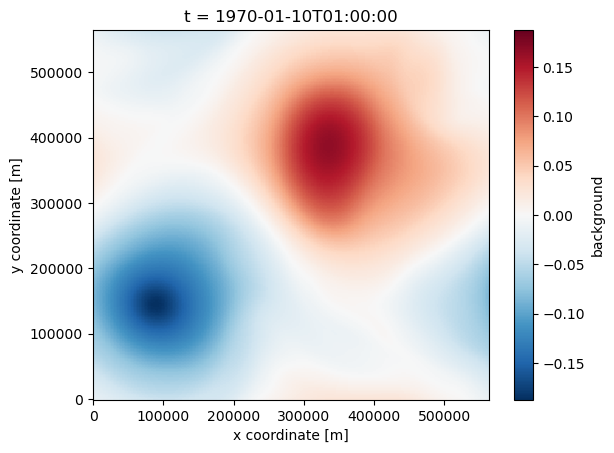

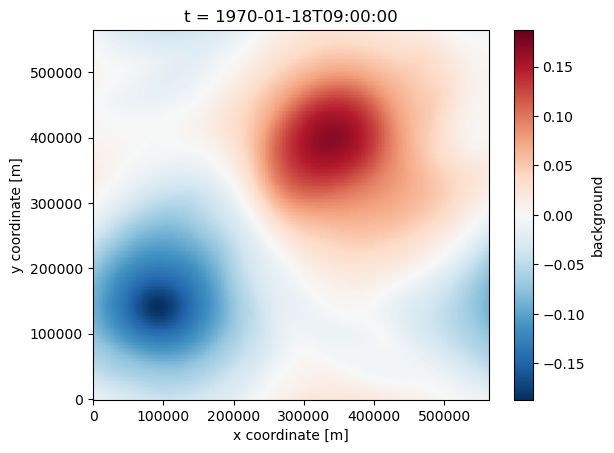

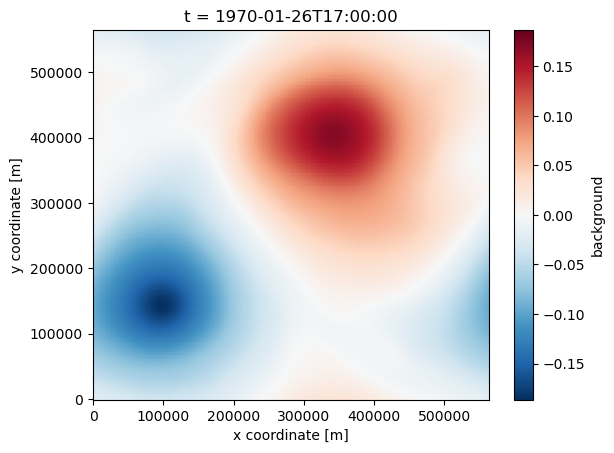

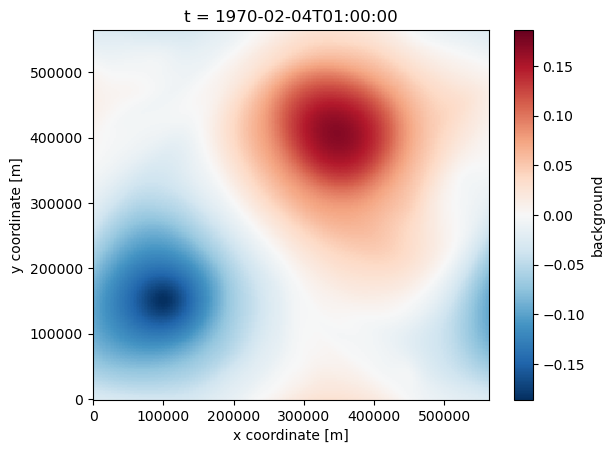

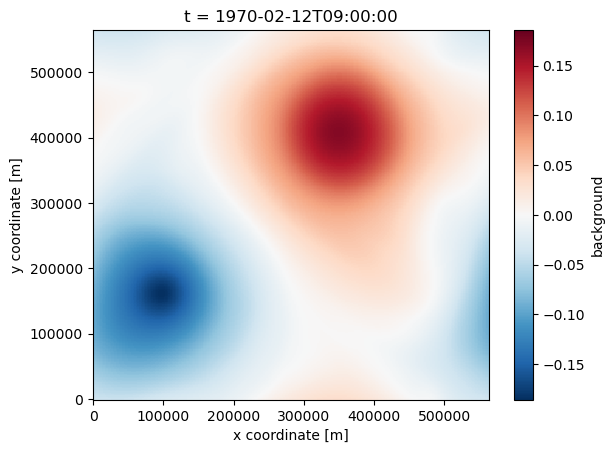

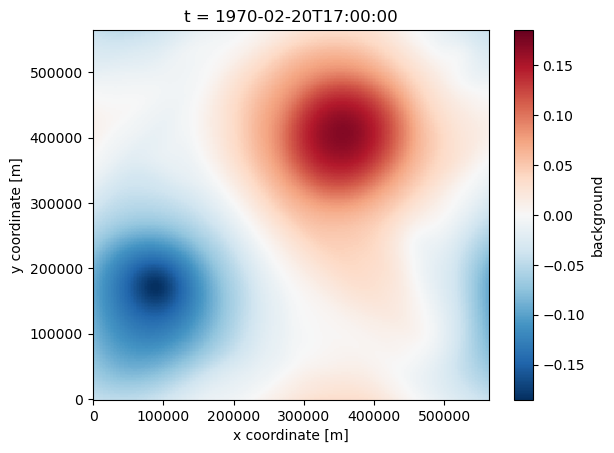

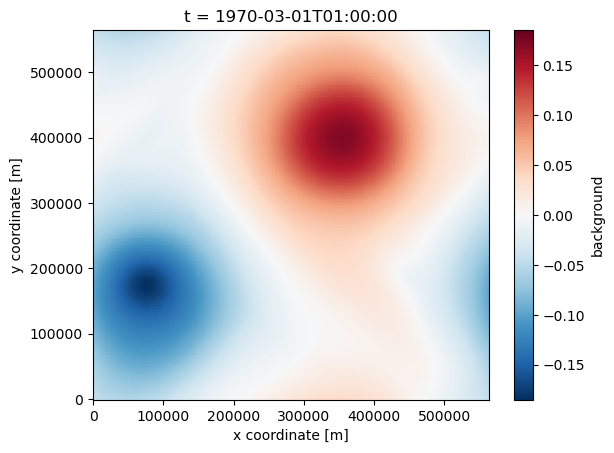

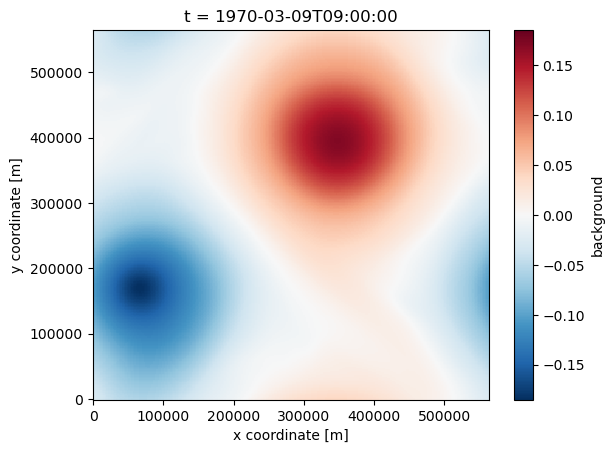

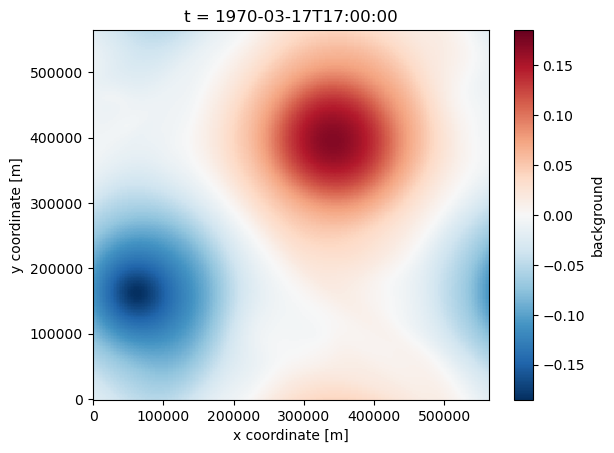

In [7]:
bg2 = xr.open_zarr(op.join(ddir,
            'wave-vortex/mrCOSTS_h/%02dhourly/%02d-recons/background.zarr' 
                          % (1,2))
                 ).background
bg4 = xr.open_zarr(op.join(ddir,
            'wave-vortex/mrCOSTS_h/%02dhourly/%02d-recons/background.zarr' 
                          % (1,4))
                 ).background

for tt in np.arange(0,len(dsc2.t)-50,200):
    bg2.isel(t=slice(25,-25)).isel(t=tt).plot(rasterized=True)
    plt.show()

In [9]:
n2 = 2
low2 = (xr.concat([dsc2.frequency_bands.isel(cluster=slice(None,n2)),
                  # dsc.frequency_bands.isel(cluster=slice(-2,None))
                 ], 'cluster'
                    # decomp_level=slice(1,None)
                ).sum(['decomp_level','cluster']) 
       + bg2)
high2 = (xr.concat([dsc2.frequency_bands.isel(cluster=slice(n2,None)),
                  # dsc.frequency_bands.isel(cluster=slice(-2,None))
                 ], 'cluster'
                    # decomp_level=slice(1,None)
                ).sum(['decomp_level','cluster']) 
       )
n4 = 3
low4 = (xr.concat([dsc4.frequency_bands.isel(cluster=slice(None,n4)),
                  # dsc.frequency_bands.isel(cluster=slice(-2,None))
                 ], 'cluster'
                    # decomp_level=slice(1,None)
                ).sum(['decomp_level','cluster']) 
       + bg4)
low2

<xarray.DataArray (t: 1729, y: 256, x: 256)>
dask.array<add, shape=(1729, 256, 256), dtype=float64, chunksize=(10, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * t        (t) datetime64[ns] 1970-01-09 1970-01-09T01:00:00 ... 1970-03-22
  * x        (x) float64 0.0 2.209e+03 4.418e+03 ... 5.611e+05 5.633e+05
  * y        (y) float64 0.0 2.209e+03 4.418e+03 ... 5.611e+05 5.633e+05

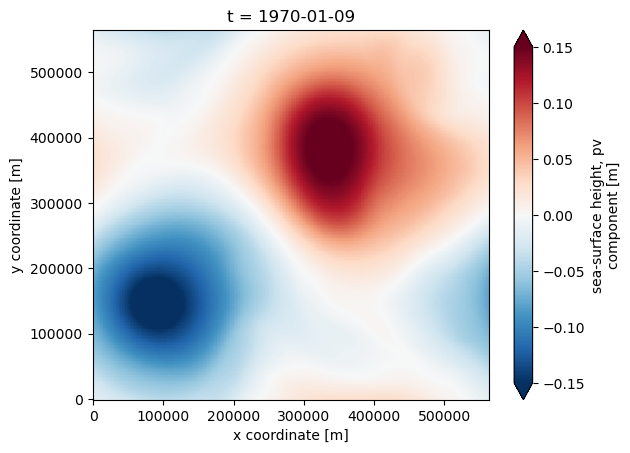

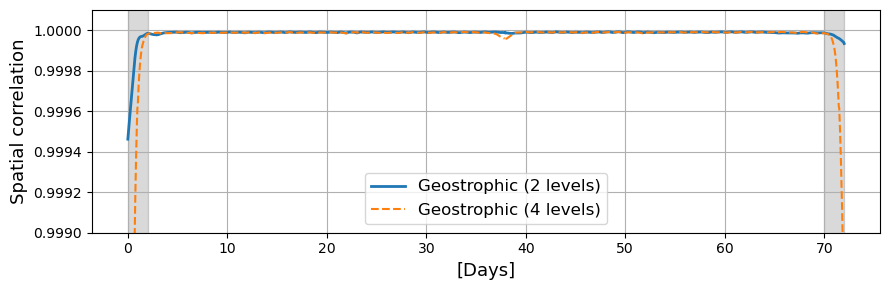

In [16]:
SSHg2 = ds.ssh_pv[::2]
SSHg2.isel(t=0).plot(rasterized=True, vmax=.15)

rcoDMD2 = xr.corr(SSHg2, low2, 
                 dim=['y','x'])
rcoDMD4 = xr.corr(SSHg2, low4, 
                 dim=['y','x'])

fig, ax = plt.subplots(figsize=(9,3))
fig.set_tight_layout(True)

ax.fill_between(np.array([0, 48.*3600/86400]), 
                .96, 1.002, color='k', alpha=.15)
ax.fill_between(np.array([(len(SSHg2)-1-48)*3600./86400, 
                          (len(SSHg2)-1)*3600./86400]), 
                .96, 1.002, color='k', alpha=.15)
ax.plot(np.arange(0,len(SSHg2))*3600/86400, rcoDMD2, lw=2,
        label=r"Geostrophic (2 levels)")
ax.plot(np.arange(0,len(SSHg2))*3600/86400, rcoDMD4, '--',
        label=r"Geostrophic (4 levels)")

ax.legend(loc='lower center', fontsize=12)
ax.set_ylim([.999,1.0001])
ax.set_ylabel(r"Spatial correlation", fontsize=13)
ax.set_xlabel(r"[Days]", fontsize=13)
ax.grid(True)
plt.savefig(op.join(ddir,'Figs/W-V_mrCOSTS_correlation.pdf'))

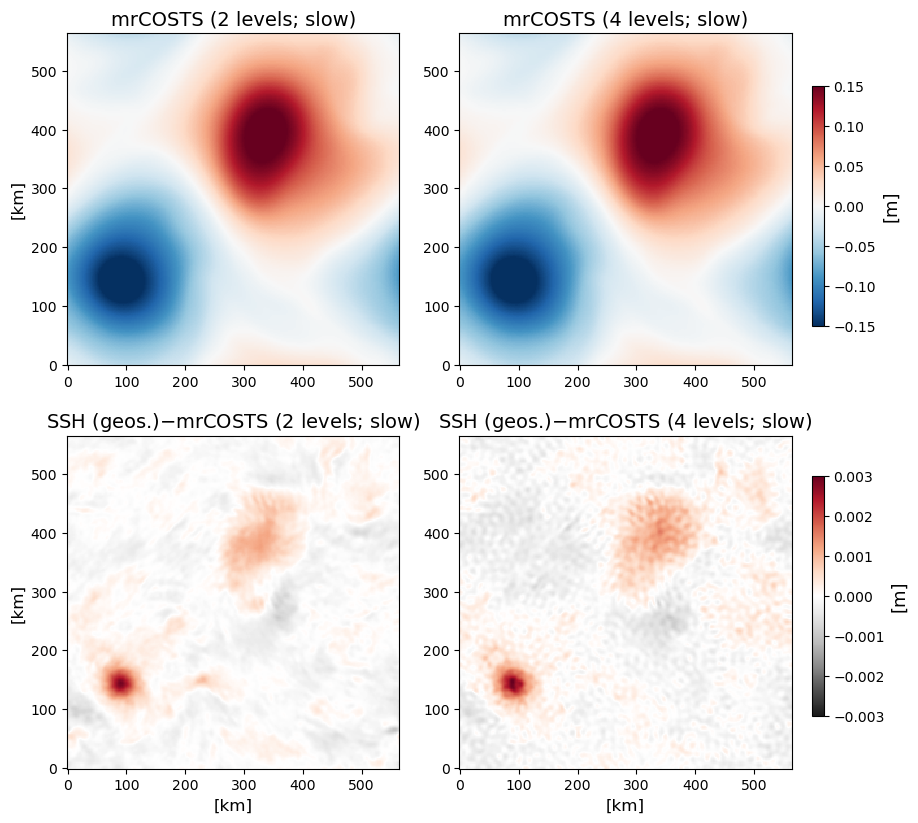

In [17]:
tt = 100

fig, axes = plt.subplots(figsize=(10,10), nrows=2, ncols=2)
# fig.set_tight_layout(True)

im0 = axes[0,0].pcolormesh(ds.x*1e-3, ds.y*1e-3,
                     low2.isel(t=tt), 
                     rasterized=True, vmax=.15, vmin=-.15, cmap='RdBu_r')
im1 = axes[1,0].pcolormesh(ds.x*1e-3, ds.y*1e-3,
                     (SSHg2.isel(t=tt) - low2.isel(t=tt).real.data), 
                     rasterized=True,
                     cmap='RdGy_r', vmax=.003, vmin=-.003)
axes[0,1].pcolormesh(ds.x*1e-3, ds.y*1e-3,
                     low4.isel(t=tt), 
                     rasterized=True, vmax=.15, vmin=-.15, cmap='RdBu_r')
axes[1,1].pcolormesh(ds.x*1e-3, ds.y*1e-3,
                     (SSHg2.isel(t=tt) - low4.isel(t=tt).real.data), 
                     rasterized=True,
                     cmap='RdGy_r', vmax=.003, vmin=-.003)

axes[0,0].set_aspect('equal')
axes[1,0].set_aspect('equal')
axes[0,1].set_aspect('equal')
axes[1,1].set_aspect('equal')

axes[0,0].set_title(r"mrCOSTS (2 levels; slow)", fontsize=14)
axes[1,0].set_title(r"SSH (geos.)$-$mrCOSTS (2 levels; slow)", fontsize=14)
axes[0,1].set_title(r"mrCOSTS (4 levels; slow)", fontsize=14)
axes[1,1].set_title(r"SSH (geos.)$-$mrCOSTS (4 levels; slow)", fontsize=14)

axes[0,0].set_ylabel(r"[km]", fontsize=12)
axes[1,0].set_ylabel(r"[km]", fontsize=12)
axes[1,0].set_xlabel(r"[km]", fontsize=12)
axes[1,1].set_xlabel(r"[km]", fontsize=12)

fig.subplots_adjust(right=.85, hspace=.1, wspace=.18) 
cbax0 = fig.add_axes([0.87, 0.57, 0.012, 0.24])
cbar0 = fig.colorbar(im0, orientation='vertical', cax=cbax0)
cbar0.set_label(r"[m]", fontsize=13)

cbax1 = fig.add_axes([0.87, 0.18, 0.012, 0.24])
cbar1 = fig.colorbar(im1, orientation='vertical', cax=cbax1)
cbar1.set_label(r"[m]", fontsize=13)

plt.savefig(op.join(ddir,'Figs/W-V_mrCOSTS.pdf'))

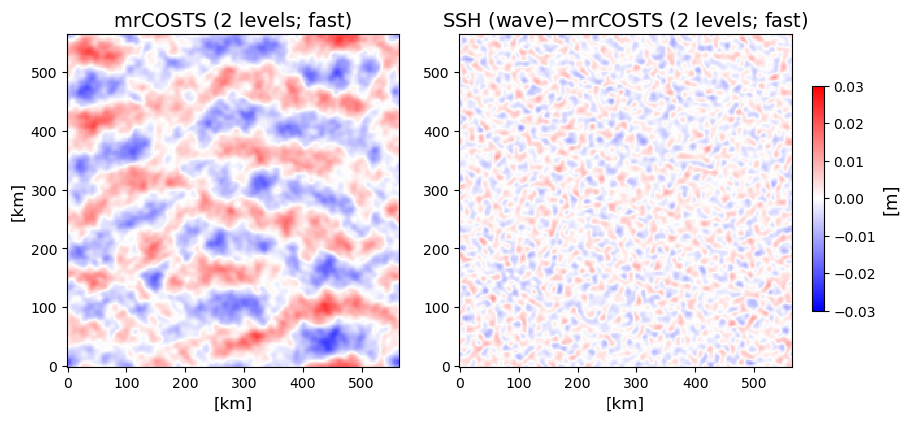

In [17]:
SSHw2 = ds.ssh_w[::2]

tt = 100

fig, axes = plt.subplots(figsize=(10,4.5), nrows=1, ncols=2)
# fig.set_tight_layout(True)

im0 = axes[0].pcolormesh(ds.x*1e-3, ds.y*1e-3,
                     high2.isel(t=tt), 
                     rasterized=True, vmax=.03, vmin=-.03, cmap='bwr')
im1 = axes[1].pcolormesh(ds.x*1e-3, ds.y*1e-3,
                     (SSHw2.isel(t=tt) - high2.isel(t=tt).real.data), 
                     rasterized=True,
                     cmap='bwr', vmax=.03, vmin=-.03)
# axes[0,1].pcolormesh(ds.x*1e-3, ds.y*1e-3,
#                      low4.isel(t=tt), 
#                      rasterized=True, vmax=.15, vmin=-.15, cmap='RdBu_r')
# axes[1,1].pcolormesh(ds.x*1e-3, ds.y*1e-3,
#                      (SSHg2.isel(t=tt) - low4.isel(t=tt).real.data), 
#                      rasterized=True,
#                      cmap='RdGy_r', vmax=.003, vmin=-.003)

axes[0].set_aspect('equal')
axes[1].set_aspect('equal')

axes[0].set_title(r"mrCOSTS (2 levels; fast)", fontsize=14)
axes[1].set_title(r"SSH (wave)$-$mrCOSTS (2 levels; fast)", fontsize=14)

axes[0].set_ylabel(r"[km]", fontsize=12)
axes[0].set_xlabel(r"[km]", fontsize=12)
axes[1].set_xlabel(r"[km]", fontsize=12)

fig.subplots_adjust(right=.85, hspace=.1, wspace=.18) 
cbax0 = fig.add_axes([0.87, 0.25, 0.012, 0.5])
cbar0 = fig.colorbar(im0, orientation='vertical', cax=cbax0)
cbar0.set_label(r"[m]", fontsize=13)

plt.savefig(op.join(ddir,'Figs/W-V_mrCOSTS_IW.pdf'))